# Pulsar Problem Introduction

**Author:** [Dr. Robert Lyon](http://www.scienceguyrob.com)

**Contact:** robert.lyon@manchester.ac.uk

**Institution:** University of Manchester

**Affiliation:** SKA Group, Time Domain Team (TDT)

**Version:** 1.0

**Date: 11/04/2018**

## Introduction
This notebook introduces the basic concepts/process underpinning pulsar candidate classification. The content presented here was originally written to support a talk I delivered at European Week of Astronomy and Space Science (EWASS) meeting in 2018. The talk is entitled: 

*Imbalanced Learning In Astronomy*

Note that this notebook requires Python 3.6.

## Code & License
The code and the contents of this notebook are released under the GNU GENERAL PUBLIC LICENSE, Version 3, 29 June 2007. The images are exempt from this, as some are used in publications I've written in the past. If you'd like to use the images please let me know, and I'll sort something out.

## Citation Request

I kindly request that if you make use of the notebook, please cite the work using the following $\textrm{Bibtex}$ source.

## Pulsar Problem

Pulsar data is extremely imbalanced. There are typically 10,000 non-target class examples, for every example of interest. In the sections that follow I show how pulsar data can be read, pre-processed, scaled, and machine learning features extracted. This will demonstrate the basic principles behind how we do machine learning in practice.

### Example Data
The input data consists of integrated pulse profiles, collected during the Medium Latitude portion of the High Time Resolution Universe Survey (HTRU) (see Thornton 2013 and Bates et. al. 2012). The data is comprised of $1,586$ pulsar and $8,852$ non-pulsar candidate profiles. Each profile contains exactly 128 phase bins. The data contains 725 of the known 1,108 pulsars (known at the time) in the Medium Latitude survey region (see Levin 2012), along with re-detections and harmonics. The data also contains noise examples, along with strong and weak forms of Radio Frequency Interference (RFI). This data is not to be confused with the [HTRU 2 feature data](https://dx.doi.org/10.6084/m9.figshare.3080389.v1) made available by Lyon et. al. (2016) - the feature data contains only machine learning features extracted from candidates, whilst this data set is made up of integrated pulse profiles only.

### Loading the Data

Here we simply load in the integrated pulse profile data, from files in the provided distribution. There are two files to be read in. The first contains integrated profiles for pulsars, the second contains noise and RFI profiles.

In [32]:
# Plotting library.
import matplotlib.pyplot as plt

# For some math we need to do.
import numpy as np

# The HTRU 2 profile data is split - one file containing the real pulsar
# profiles, one file containing noise/interference profiles. We load both
# these data sources here. First we construct relative paths to the files.
data_dir = 'data/HTRU2'
pulsar_file = data_dir + '/HTRU2_pulsar.csv'
nonpulsar_file = data_dir + '/HTRU2_nonpulsar.csv'

# Now simply load the data.
pulsar_data = np.genfromtxt(pulsar_file, dtype=np.int,delimiter=',')
non_pulsar_data = np.genfromtxt(nonpulsar_file, dtype=np.int,delimiter=',')

# Print overview details.
print ('\n\nTotal number of pulsar profiles: ', len(pulsar_data))
print ('Total number of noise/RFI profiles: ', len(non_pulsar_data))



Total number of pulsar profiles:  1586
Total number of noise/RFI profiles:  8852


Now we plot a single example of both classes, to show what the data looks like. First the pulsar example.

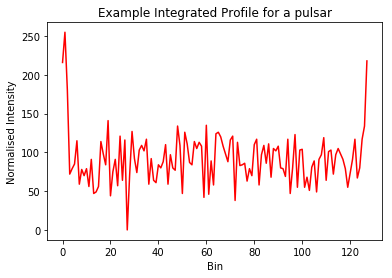

In [33]:
plt.figure(1)
plt.plot(pulsar_data[7], 'r')
plt.xlabel('Bin')
plt.ylabel('Normalised Intensity')
plt.title('Example Integrated Profile for a pulsar')
plt.show()

It is clear that the peak is not in the centre. For most examples it is, but not for all. How about for the non-pulsar examples?

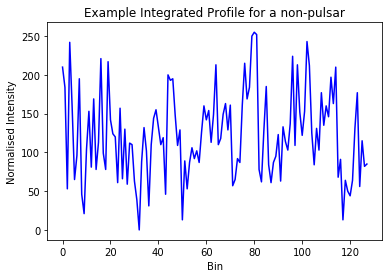

In [34]:
plt.figure(2)
plt.plot(non_pulsar_data[0], 'b')
plt.xlabel('Bin')
plt.ylabel('Normalised Intensity')
plt.title('Example Integrated Profile for a non-pulsar')
plt.show()

The non-pulsar example doesn't appear to be correctly centred either. So we centre the data using a simple function. We define this function below:

In [35]:
import operator

def centre_on_peak(data):
    """
    Centre the data such that the maximum y-axis value is in the
    centre of the data.

    Parameters
    ----------
    :param data: the data to be centred.

    Returns
    ----------
    :return: the centred data array.
    """
    # Stores the centred data.
    centred_data = []

    # Get the index of the maximum value.
    index, value = max(enumerate(data), key=operator.itemgetter(1))

    # Find midpoint of the data.
    midpoint = int(len(data)/2)

    # Figure out the shift required to centre the data (put max value in centre bin).
    n = midpoint - index  # N gives the number of bins the data should be shifted.
    a = n % len(data)

    # Apply the correction.
    centred_data = np.concatenate([data[-a:],data[:-a]])

    return centred_data

Now we execute this centering function.

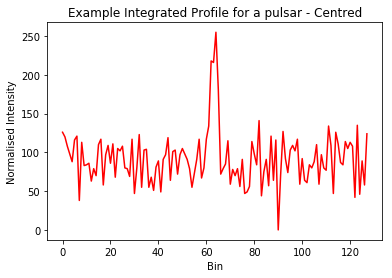

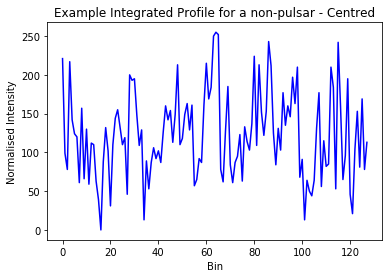

In [36]:
# Here we simply loop over each item in the data arrays,
# and update their values.
for i in range(0, len(pulsar_data)):
    pulsar_data[i] = centre_on_peak(pulsar_data[i])
    
for i in range(0, len(non_pulsar_data)):
    non_pulsar_data[i] = centre_on_peak(non_pulsar_data[i])
    
plt.figure(3)
plt.plot(pulsar_data[7], 'r')
plt.xlabel('Bin')
plt.ylabel('Normalised Intensity')
plt.title('Example Integrated Profile for a pulsar - Centred')
plt.show()

plt.figure(4)
plt.plot(non_pulsar_data[0], 'b')
plt.xlabel('Bin')
plt.ylabel('Normalised Intensity')
plt.title('Example Integrated Profile for a non-pulsar - Centred')
plt.show()

Now the data is correctly loaded and centred, we can move on. How about we compute some machine learning features from the data? We can use the features devised by Lyon et.al. 2016. The code provided below will allow us to extract these.

---

In [37]:
def compute_features(data):
    """
    Computes machine learning feature values for the supplied data array.

    Parameters
    ----------
    :param data: a data array.

    Returns
    ----------
    :return: the computed machine learning features as a list [mean, stdev, shew, kurtosis].
    """
    if data is not None:  # Check data is not empty

        if len(data) > 0:

            # Sums computed during calculation.
            mean_sum = 0
            mean_subtracted_sum_power_2 = 0
            mean_subtracted_sum_power_3 = 0
            mean_subtracted_sum_power_4 = 0

            # The number of data points in the array.
            n = len(data)

            # Necessary first loop to calculate the sum, min and max
            for d in data:
                mean_sum += float(d)
            
            if mean_sum > 0 or mean_sum < 0:  # If the mean is less than or greater than zero (should be)
                
                # Update the mean value.
                mean_value = mean_sum / float(n)

                # Now try to compute the standard deviation, using
                # the mean computed above... we also compute values in
                # this loop required to compute the excess Kurtosis and
                # standard deviation.

                for d in data:
                    
                    mean_subtracted_sum_power_2 += np.power((float(d) - mean_value), 2.0)

                    # Used to compute skew
                    mean_subtracted_sum_power_3 += np.power((float(d) - mean_value), 3.0)

                    # Used to compute Kurtosis
                    mean_subtracted_sum_power_4 += np.power((float(d) - mean_value), 4.0)

                # Update the standard deviation value.
                stdev = np.sqrt(mean_subtracted_sum_power_2 / (n - 1.0))
                # Next try to calculate the excess Kurtosis and skew using the
                # information gathered above.

                one_over_n = 1.0 / n  # Used multiple times...

                kurt = ((one_over_n * mean_subtracted_sum_power_4) / np.power((one_over_n * mean_subtracted_sum_power_2), 2) ) - 3

                skew = (one_over_n * mean_subtracted_sum_power_3) / np.power(np.sqrt(one_over_n * mean_subtracted_sum_power_2), 3)
                    
                return [mean_value, stdev, skew, kurt]
                
            else:  # Data sums to zero, i.e. no data!
                return [0,0,0,0]
            
        else:  # Data empty for some reason...
            return [0,0,0,0]

### Feature Extraction Unit Test
Now we want to test our feature extraction function works correctly. To do this, we write two important types of test.

#### Test 1: Expected Outputs from Theory
A Gaussian distribution with a mean of 0, and a standard deviation of 1, should have a skew of 0, and a kurtosis of 0. These values are derivable from theory, and are known to be correct. We can test our function works well, by comparing the values it computes for such a Gaussian distribution. However, I don't have the data points describing a perfect Gaussian distribution readily at hand. So to perform such a test, I use a simple trick. I instead use a Gaussian random number generator, to generate an approximately perfect distribution. I can then compare the outputs of my function computed over this distribution, to the expected values from theory. Whilst the results will not match exactly, it should give us an indication of how the function is performing.

#### Test 2: Our output vs. Numpy
We can also compare the values obtained by our function, to those produced by the in-built numpy functions. If our function produces outputs close to those expected from theory, and identical to those produced by numpy, we can have confidence that our function is correct.

At this point, you may wonder why I bother with the comparison to the theoretical. Perhaps you're thinking, *"Geez Rob, why not just compare to the numpy function?"*. Well, sometimes numpy functions have bugs, and we need to be sure that we are robust against them.


Ok, now we perform the first two test for a approximately perfect Gaussian distribution. Note that we use the sample standard deviation, and values are rounded to 12 decimal places.

In [38]:
import random as rnd
from scipy.stats import skew
from scipy.stats import kurtosis

# Now generate some random data, and test the extracted values.
gaussian_data = []
for i in range(0, 100000):
    gaussian_data.append(rnd.gauss(0.0, 1.0))

# Get the feature data
[mean_,stdev_,skew_,kurt_] = compute_features(gaussian_data)

# Check the results
print ('Test 1 for Gaussian Distribution: Our computed values vs. theoretical values\n')
print ('\tGaussian data mean: ' , str('%.12f' % mean_) , '\t\texpected: 0.0')
print ('\tGaussian data stdev:' , str('%.12f' % stdev_), '\t\texpected: 1.0')
print ('\tGaussian data skew: ' , str('%.12f' % skew_) , '\t\texpected: 0.0')
print ('\tGaussian data kurt: ' , str('%.12f' % kurt_) , '\t\texpected: 0.0\n\n')

# Check the results
print ('Test 2 for Gaussian Distribution: Our computed values vs. numpy function values\n')
print ('\tGaussian data mean: ' , str('%.12f' % mean_) , '\t\tnumpy: ' , str('%.12f' % np.mean(gaussian_data)))
print ('\tGaussian data stdev:' , str('%.12f' % stdev_) , '\t\tnumpy: ' , str('%.12f' % np.std(gaussian_data,ddof=1)))
print ('\tGaussian data skew: ' , str('%.12f' % skew_) , '\t\tnumpy: ' , str('%.12f' % skew(gaussian_data)))
print ('\tGaussian data kurt: ' , str('%.12f' % kurt_) , '\t\tnumpy: ' , str('%.12f' % kurtosis(gaussian_data)), '\n\n')

Test 1 for Gaussian Distribution: Our computed values vs. theoretical values

	Gaussian data mean:  -0.001636820986 		expected: 0.0
	Gaussian data stdev: 1.000969581305 		expected: 1.0
	Gaussian data skew:  -0.010071590652 		expected: 0.0
	Gaussian data kurt:  0.006428201885 		expected: 0.0


Test 2 for Gaussian Distribution: Our computed values vs. numpy function values

	Gaussian data mean:  -0.001636820986 		numpy:  -0.001636820986
	Gaussian data stdev: 1.000969581305 		numpy:  1.000969581305
	Gaussian data skew:  -0.010071590652 		numpy:  -0.010071590652
	Gaussian data kurt:  0.006428201885 		numpy:  0.006428201885 




It's clear that the function is producing values very close to those expected from the theory. It is also clear that our function is giving the same answers to the numpy function. So it appears to be working well. Now for another test, this time on the uniform distribution.

In [39]:
# Now generate some random data, and test the extracted values.
uniform_data = []
for i in range(0, 100000):
    uniform_data.append(rnd.uniform(0.0, 1.0))

[mean_,stdev_,skew_,kurt_] = compute_features(uniform_data)
        
# Standard deviation of uniform distribution is given by:
#
# Sqrt((1/12) (b-a)^2)
#
# where a is the lower limit, and b the upper limit. So...
expected_std = np.sqrt((1.0/12.0) * np.power((1.0-0.0), 2))

# Kurtosis of uniform distribution is given by:
#
# -(6.0/5.0)
expected_kurt = -(6.0/5.0)

# Skew of uniform distribution is given by:
#
# 0
expected_skew = 0

# See this site for details on these computations:
# http:#mathworld.wolfram.com/UniformDistribution.html

# Check the results
print ('Test 1 for Uniform Distribution: Our computed values vs. theoretical values\n')
print ('\tUniform data mean: ' , str('%.12f' % mean_) , '\t\texpected: 0.5')
print ('\tUniform data stdev:' , str('%.12f' % stdev_), '\t\texpected: ' , str(expected_std))
print ('\tUniform data skew: ' , str('%.12f' % skew_) , '\t\texpected: ' , str(expected_skew))
print ('\tUniform data kurt: ' , str('%.12f' % kurt_) , '\t\texpected: ' , str(expected_kurt) , '\n\n')

# Check the results
print ('Test 2 for Uniform Distribution: Our computed values vs. numpy function values\n')
print ('\tUniform data mean: ' , str('%.12f' % mean_) , '\t\tnumpy: ' , str('%.12f' % np.mean(uniform_data)))
print ('\tUniform data stdev:' , str('%.12f' % stdev_), '\t\tnumpy: ' , str('%.12f' % np.std(uniform_data,ddof=1)))
print ('\tUniform data skew: ' , str('%.12f' % skew_) , '\t\tnumpy: ' , str('%.12f' % skew(uniform_data)))
print ('\tUniform data kurt: ' , str('%.12f' % kurt_) , '\t\tnumpy: ' , str('%.12f' % kurtosis(uniform_data)))

Test 1 for Uniform Distribution: Our computed values vs. theoretical values

	Uniform data mean:  0.500053760973 		expected: 0.5
	Uniform data stdev: 0.287984271227 		expected:  0.288675134595
	Uniform data skew:  0.002904046338 		expected:  0
	Uniform data kurt:  -1.196982538612 		expected:  -1.2 


Test 2 for Uniform Distribution: Our computed values vs. numpy function values

	Uniform data mean:  0.500053760973 		numpy:  0.500053760973
	Uniform data stdev: 0.287984271227 		numpy:  0.287984271227
	Uniform data skew:  0.002904046338 		numpy:  0.002904046338
	Uniform data kurt:  -1.196982538612 		numpy:  -1.196982538612


It's clear that the function is producing values very close to those expected from the theory. It is also clear that our function is giving the same answers to the numpy function. Based on these results, I trust that the function is correct.

---

### Scaling
Pulsar data is often scaled to some nuermical range, often 0 to 255. Here I provide a function that can perform the scaling.

In [40]:
def scale(data,new_min, new_max):
    """
    Scales data to within the range [new_min,new_max].

    Parameters
    ----------
    :param data: the data to scale.
    :param new_min: the new minimum value for the data range.
    :param new_max: the new maximum value for the data range.

    Returns
    ----------
    :return: A new array with the data scaled to within the range [new_min,new_max].
    """
    min_ = min(data)
    max_ = max(data)

    new_data = []

    for n in range(len(data)):

        value = data[n]
        x = (new_min * (1-( (value-min_) /( max_- min_ )))) + (new_max * ( (value-min_) /( max_- min_ ) ))
        new_data.append(x)

    return new_data

## Pulsar Classification
So far we've loaded the pulsar data, decided upon a scaling, and chosen our features. Now lets do some basic classification.

In [41]:
from sklearn.model_selection import train_test_split
    
X = [] # Stores the feature data.
Y = [] # Stores the class labels.

# Add pulsar examples.
for i in range(0, len(pulsar_data)):
    
    # Now here we extract the features with the call
    # to compute_features(). We also scale each profile
    # so that its values fall in the range [0,1]. This is
    # done via the call to scale(...).
    X.append(compute_features(scale(pulsar_data[i],0.0,1.0)))
    Y.append(1)

# Add non-pulsar examples.
for i in range(0, len(non_pulsar_data)):
             
    # Now here we extract the features with the call
    # to compute_features(). We also scale each profile
    # so that its values fall in the range [0,1]. This is
    # done via the call to scale(...).
    X.append(compute_features(scale(non_pulsar_data[i],0.0,1.0)))
    Y.append(0)

Now let's create a test/train data set split.

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.999)

print ('\nExamples in training set: ' , str(len(x_train)))
print ('Examples in testing set: ' , str(len(x_test)))
             
# There should be 4 features per example. Lets just check this is
# the case.
print ('Dimensions of training set: ' , str(np.asarray(x_train).shape))
print ('Dimensions of testing set: ' , str(np.asarray(x_test).shape))    


Examples in training set:  10
Examples in testing set:  10428
Dimensions of training set:  (10, 4)
Dimensions of testing set:  (10428, 4)


Now we build and test the classifier. We'll just use a basic calssfier here to keep things simple.

In [43]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

# First train the classifier with call to fit.
classifier.fit(x_train, y_train)

# Now obtain the classifiers 'score'
accuracy = classifier.score(x_test, y_test)
print ("Naive Bayes Classifier accuracy: ", (100* accuracy), "%.")

Naive Bayes Classifier accuracy:  95.3778289221 %.


Here we've built a basic classifier on just the integrated pulse profile data of pulsar candidates. The results are quite good - however in the real world things aren't so easy. Stay tuned for more datasets that I'll be able to share - perhaps then you'll find out how tricky pulsar classification is.

## References

Bates S. D., Bailes M., Barsdell B. R., Bhat N. D. R., Burgay M., Burke-Spolaor S., Champion D. J., et al., 2012, *"The High Time Resolution Universe Pulsar Survey - VI. An artificial neural network and timing of 75 pulsars"*, MNRAS, 427, pp.1052-1065, [DOI:10.1111/j.1365-2966.2012.22042.x](https://dx.doi.org/10.1111/j.1365-2966.2012.22042.x).

Bishop C. M., 2006, *"Pattern Recognition and Machine Learning"*, Springer.

He H. and Garcia E., 2009, *"Learning from Imbalanced Data"*, Knowledge and Data
Engineering, IEEE Transactions on, 21(9), pp.1263-1284.

Levin L., 2012, *"A search for radio pulsars: from millisecond pulsars to magnetars"*, PhD thesis, Swinburne University.

Lyon R. J., Stappers B. W., Cooper S., Brooke J. M., Knowles J.D., 2016, *"Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach"*, MNRAS, 459 (1):1104-1123, [DOI:10.1093/mnras/stw656](https://dx.doi.org/10.1093/mnras/stw656)

Lyon R. J., 2016, *"Why Are Pulsars Hard To Find?"*, PhD thesis, University of Manchester.

Thornton D., 2013, *"The High Time Resolution Radio Sky"*, PhD thesis, University of Manchester.